In [11]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt

### Data Preparation

In [12]:
def prepare(stationfile, lead_hrs=3):
    """
    lead_hrs = minimum # of hours before observation used in prediction (integer)
    """

    # parsing and cleaning data from CSV file
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    data = pd.read_csv(stationfile,low_memory=False, parse_dates=['valid'], date_parser=dateparse)
    data = data.dropna(0,how='any')
    list_vars = ['tmpf', 'relh', 'dwpf', 'drct', 'sknt', 'alti' , 'vsby']
    list_hours = ['1 hour', '2 hour', '3 hour', '4 hour', '5 hour', '6 hour', '7 hour', '8 hour', '9 hour', '10 hour', '11 hour', '12 hour']
    list_hours = list_hours[(lead_hrs-1):]
    features_list = ['{} {}'.format(var, hour) for var in list_vars for hour in list_hours]
    X = np.array(data[features_list])
    
    # setting low visibility rows to '1', others to '0' 
    data.loc[data['vsby'] < 1, 'vsby' ] = 1
    data.loc[data['vsby'] > 1, 'vsby' ] = 0
    Y = data['vsby']

    # Spliting into Training, Validation and Testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

    # Normalizing Data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
        
    return X_train, X_test, X_val, y_train, y_test, y_val

### Neural Network definition, training and prediction

In [13]:

def make_model(shape):
    model = Sequential()
    model.add(Dense(64, input_dim=shape, activation='relu', kernel_initializer = 'normal'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_model(model, X_train, X_val, y_train, y_val):
    checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', verbose=1, save_best_only=True)
    model.fit(np.array(X_train), np.array(y_train), batch_size=1024,epochs=20, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=0)
    return model
    
def predict(model, X_test, y_test):    
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    cm = confusion_matrix(y_test, predictions, labels=[0,1])
    return cm
    
def metrics(cm, metric):    
    tn, fp, fn, tp = cm.ravel()
    if metric == 'recall':
        return float(tp)/(tp+fn)
    if metric == 'specificity':
        return float(tn)/(tn+fp)
    if metric == 'precision':
        return float(tp)/(tp+fp)
    if metric == 'miss_rate':
        return float(fn)/(fn+tp)
    if metric == 'accuracy':
        return (float(tp)+tn)/(tp+tn+fp+fn)


## Model Train and Run:


In [15]:
# for airport in ['SUMU', 'SAEZ']: 
for airport in ['SBCT']: 
    for lead in range(1,9):
        print(airport, lead)
        X_train, X_test, X_val, y_train, y_test, y_val = prepare('{}.csv'.format(airport), lead_hrs=lead)
        model = make_model(X_train.shape[1])
        model = train_model(model, X_train, X_val, y_train, y_val)
        cm = predict(model, X_test, y_test)

        try:
            recall = metrics(cm,'recall')
        except ZeroDivisionError:
            recall = np.nan
        try:    
            precision = metrics(cm, 'precision')
        except ZeroDivisionError:
            precision = np.nan
            
        f = open('stats.csv', 'a+')
        header = 'airport,lead,recall,precision'
        string_out='{},{},{},{}\n'.format(airport,lead,recall,precision)
        f.write(string_out)
        f.close()

print('Done')

SBCT 1

Epoch 00001: val_loss improved from inf to 0.07343, saving model to weights.best.hdf5

Epoch 00002: val_loss improved from 0.07343 to 0.05437, saving model to weights.best.hdf5

Epoch 00003: val_loss improved from 0.05437 to 0.04850, saving model to weights.best.hdf5

Epoch 00004: val_loss improved from 0.04850 to 0.04543, saving model to weights.best.hdf5

Epoch 00005: val_loss improved from 0.04543 to 0.04444, saving model to weights.best.hdf5

Epoch 00006: val_loss improved from 0.04444 to 0.04223, saving model to weights.best.hdf5

Epoch 00007: val_loss improved from 0.04223 to 0.04193, saving model to weights.best.hdf5

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss improved from 0.04193 to 0.04039, saving model to weights.best.hdf5

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not impr


Epoch 00002: val_loss improved from 0.11540 to 0.06708, saving model to weights.best.hdf5

Epoch 00003: val_loss improved from 0.06708 to 0.06149, saving model to weights.best.hdf5

Epoch 00004: val_loss improved from 0.06149 to 0.06021, saving model to weights.best.hdf5

Epoch 00005: val_loss improved from 0.06021 to 0.05892, saving model to weights.best.hdf5

Epoch 00006: val_loss improved from 0.05892 to 0.05837, saving model to weights.best.hdf5

Epoch 00007: val_loss improved from 0.05837 to 0.05809, saving model to weights.best.hdf5

Epoch 00008: val_loss improved from 0.05809 to 0.05766, saving model to weights.best.hdf5

Epoch 00009: val_loss improved from 0.05766 to 0.05715, saving model to weights.best.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

  station  lead    recall  precision
0    SBCT     1  0.372093   0.489796
1    SBCT     2  0.372093   0.268156
2    SBCT     3  0.248062   0.329897
3    SBCT     4  0.062016   0.571429
4    SBCT     5  0.069767   0.290323
5    SBCT     6  0.178295   0.328571
6    SBCT     7  0.108527   0.350000
7    SBCT     8  0.054264   0.241379


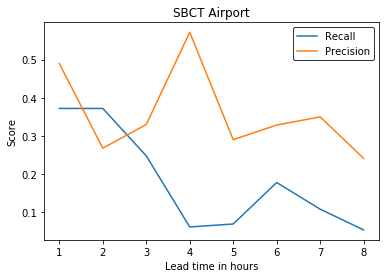

In [16]:
def plot(airport):
    plt.clf()
    df = pd.read_csv('stats.csv', names=['station','lead','recall','precision'])
    print(df[df.station == airport])
    x = df[df.station == airport].lead

    plt.plot(x,df[df.station == airport].recall, label='Recall')
    plt.plot(x,df[df.station == airport].precision, label='Precision')
    plt.xlabel('Lead time in hours')
    plt.ylabel('Score')
    plt.legend().get_frame().set_edgecolor("k")
    plt.title('{} Airport'.format(airport))
    plt.show()

# for airport in ['SUMU', 'SAEZ']:
for airport in ['SBCT']: 
    plot(airport)

,Unnamed: 0,valid,tmpf,dwpf,relh,drct,sknt,alti,vsby,tmpf 1 hour,...,vsby 3 hour,vsby 4 hour,vsby 5 hour,vsby 6 hour,vsby 7 hour,vsby 8 hour,vsby 9 hour,vsby 10 hour,vsby 11 hour,vsby 12 hour
0,0,2011-01-01 02:00:00,68.0,62.6,82.86,100.0,10.0,29.97,6.21,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2011-01-01 03:00:00,68.0,64.4,88.26,90.0,5.0,29.97,6.21,68.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2011-01-01 04:00:00,68.0,64.4,88.26,70.0,5.0,29.97,6.21,68.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2011-01-01 05:00:00,64.4,62.6,93.88,90.0,4.0,29.94,6.21,68.0,...,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2011-01-01 07:00:00,64.4,62.6,93.88,50.0,5.0,29.94,6.21,NaN,...,6.21,6.21,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
